In this notebook, I will answer these question : 

1. How each neighborhood in Boston performing in terms of ratings?
2. What is the biggest contributing factors to high price of listing? 
3. What factors about listing attribute to good review?



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
listing = pd.read_csv('data/listings.csv')
calendar = pd.read_csv('data/calendar.csv')
review = pd.read_csv('data/reviews.csv')

In [3]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [4]:
len(listing)

3585

22.6% of the dataset does not have review_scores_rating as shown below

In [5]:
print('Percentage dataset with missing rating : {}%'.format(100*len(listing[listing.review_scores_rating.isna()])/len(listing)))

Percentage dataset with missing rating : 22.677824267782427%


In [6]:
print('Percentage dataset without price : {}%'.format(100*len(listing[listing.price.isna()])/len(listing)))

Percentage dataset without price : 0.0%


Let's drop the data that doesn't have rating 

In [7]:
new_listing_df = listing.dropna(subset=['review_scores_rating'])

The ratings is left skewed. So most of the listing have high ratings.

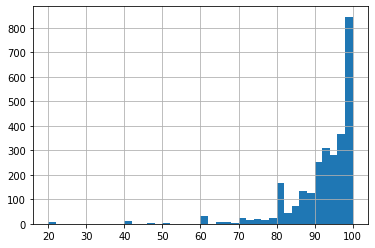

In [8]:
new_listing_df.review_scores_rating.hist(bins=40)

We can see number of listings per neighbourhood from below chart

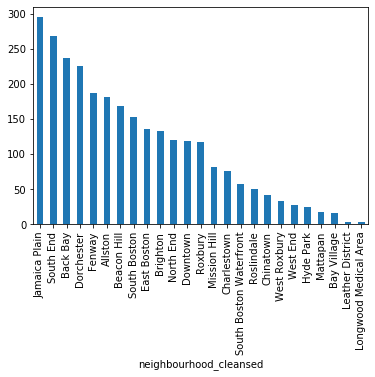

In [9]:
new_listing_df.groupby(['neighbourhood_cleansed']).id.count().sort_values(ascending=False).plot(kind='bar')

Let's see what is the ratings on the neighbourhood with high amount of listings. I put 50 as a filter of high listings. 

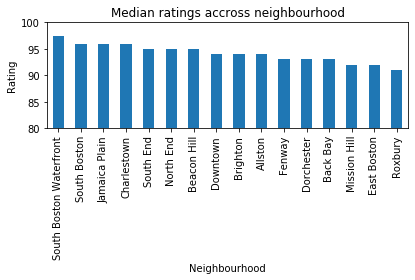

In [10]:
plt.figure()
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 50).groupby(['neighbourhood_cleansed']).review_scores_rating.median().sort_values(ascending=False).plot(kind='bar', ylim=(80,100), title='Median ratings accross neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Rating')
plt.tight_layout()
plt.savefig('Median ratings across neighbourhood')



All the neighbourhood is having >90 ratings. Roxbury has the lowest rating with South Boston Waterfront hold the top ratings.  Let's see how the neighborhood varied in price

In [11]:
new_listing_df['price'] =  [np.nan if str(x) == 'nan' else float(str(x).replace('$','').replace(',','')) for x in new_listing_df.price]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


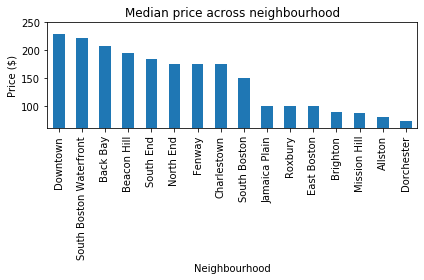

In [12]:
plt.figure()
new_listing_df.groupby(['neighbourhood_cleansed']).filter(lambda x: x['id'].count() > 50).groupby(['neighbourhood_cleansed']).price.median().sort_values(ascending=False).plot(kind='bar', ylim=(60,250), title='Median price across neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.savefig('Median price across neighbourhood',quality=100, optimize=True)



Donwtown has the highest median price while Dorchester has the lowest median price.

Next, we can check how the listing features affect the ratings. First we can determine the feature.

In [13]:
features = new_listing_df[['host_listings_count', 'host_total_listings_count', 'accommodates', 
                     'bathrooms', 'bedrooms', 'beds','guests_included','review_scores_rating','price']]

Process amenities data by splitting it into separate features

In [14]:
new_listing_df['amenities'].head(10)

1     {TV,Internet,"Wireless Internet","Air Conditio...
2     {TV,"Cable TV","Wireless Internet","Air Condit...
3     {TV,Internet,"Wireless Internet","Air Conditio...
4     {Internet,"Wireless Internet","Air Conditionin...
5     {"Cable TV","Wireless Internet","Air Condition...
6     {TV,Internet,"Wireless Internet",Kitchen,"Free...
7     {TV,Internet,"Wireless Internet","Air Conditio...
8     {"Wireless Internet","Pets live on this proper...
9     {TV,"Cable TV",Internet,"Wireless Internet","A...
10    {TV,"Wireless Internet","Air Conditioning",Kit...
Name: amenities, dtype: object

In [15]:
amenities = np.unique(np.concatenate([amns.replace('"','').replace('{','').replace('}','').split(',') for amns in new_listing_df['amenities']],axis=None))[1:]
amenity_arr = np.array([new_listing_df['amenities'].map(lambda amns: 1 if amn in amns else 0) for amn in amenities])
features = pd.concat([features, pd.DataFrame(data=amenity_arr.T, columns=amenities)], axis=1)

we can use the feature with true and false values as well.

In [16]:
for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
    features[tf_feature] = new_listing_df[tf_feature].map(lambda s: 0 if s == "f" else 1)

combining categorical feature

In [17]:
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    features = pd.concat([features, pd.get_dummies(new_listing_df[categorical_feature])], axis=1)

In [18]:
features.isna().sum()

host_listings_count          627
host_total_listings_count    627
accommodates                 627
bathrooms                    639
bedrooms                     634
                            ... 
Airbed                       627
Couch                        627
Futon                        627
Pull-out Sofa                627
Real Bed                     627
Length: 107, dtype: int64

Looking at the numbers of rows that consistent accros all features, we can drop these dirty rows

In [19]:
features = features.dropna(axis=0)

In [35]:
features.columns

Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included',
       'review_scores_rating', 'price', '24-Hour Check-in',
       ...
       'Townhouse', 'Villa', 'Entire home/apt', 'Private room', 'Shared room',
       'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'],
      dtype='object', length=107)

Let's see how the feature correlate with rating.

In [20]:
features.corr().review_scores_rating.sort_values(ascending=False)

review_scores_rating       1.000000
host_is_superhost          0.233151
Jamaica Plain              0.088224
price                      0.085690
host_identity_verified     0.077706
                             ...   
requires_license                NaN
Allston                         NaN
South Boston                    NaN
South Boston Waterfront         NaN
Entire Floor                    NaN
Name: review_scores_rating, Length: 107, dtype: float64

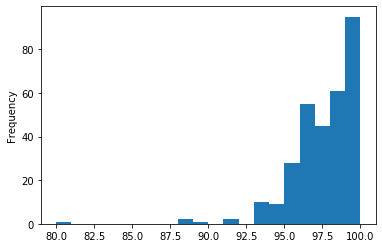

In [21]:
features[features.host_is_superhost==1].review_scores_rating.plot(kind='hist',bins=20)

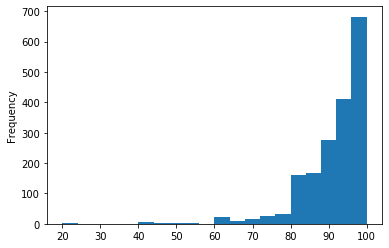

In [23]:
features[features.host_is_superhost==0].review_scores_rating.plot(kind='hist',bins=20)

From the chart we can see host_is_superhost has the highest correlation with rating and the host_identity_verfied is second place.

This is superhost definition from AirBNB :

**What is a Superhost?
Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.**

**Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.**


**We check Superhosts’ activity four times a year, to ensure that the program highlights the people who are most dedicated to providing outstanding hospitality.**

In summary, superhosts are __high quality hosts__. So, logically this should be one of the best predictor of the ratings.


We can do the same for price

In [24]:
features.corr().price.sort_values(ascending=False)

price                      1.000000
accommodates               0.577492
bedrooms                   0.547480
Entire home/apt            0.542198
beds                       0.505079
                             ...   
requires_license                NaN
Allston                         NaN
South Boston                    NaN
South Boston Waterfront         NaN
Entire Floor                    NaN
Name: price, Length: 107, dtype: float64

Accomodates and bedrooms has high correlation with price, this is make sense as the number of people and bedrooms will increase the price of rental. Surprisingly, **Downtown** (location) is not part of the feature that has high correlation with price.

Next we can do the prediction

In [25]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [26]:
clf_lr = LinearRegression()
clf_las = Lasso()
clf_rf = RandomForestRegressor()
y = features['review_scores_rating']
x = features.drop('review_scores_rating', axis='columns')
clf_lr.fit(x, y)
clf_las.fit(x, y)
clf_rf.fit(x, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
y_pred_lr = clf_lr.predict(x)
y_pred_las = clf_las.predict(x)
y_pred_rf = clf_rf.predict(x)

In [28]:
print('linear regression r2 score : ',r2_score(y, y_pred_lr))
print('lasso r2 score : ',r2_score(y, y_pred_las))
print('random forrest r2 score : ',r2_score(y, y_pred_rf))

linear regression r2 score :  0.1565322736886382
lasso r2 score :  0.045536649059475076
random forrest r2 score :  0.8802443130588729


In [29]:
r2_score(y, y_pred_lr)

0.1565322736886382

Text(0.5, 1.0, 'linear regression')

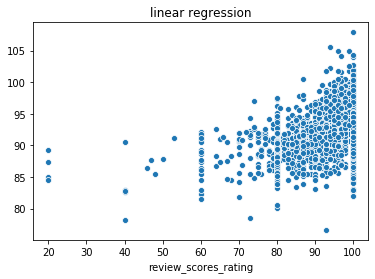

In [30]:
sns.scatterplot(y,y_pred_lr).set_title('linear regression')

Text(0.5, 1.0, 'lasso regression')

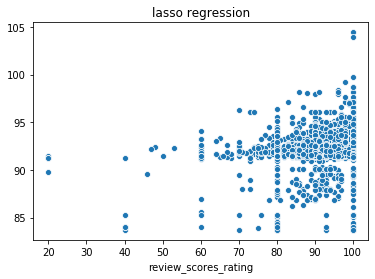

In [31]:
sns.scatterplot(y,y_pred_las).set_title('lasso regression')

Text(0.5, 1.0, 'Random forrest')

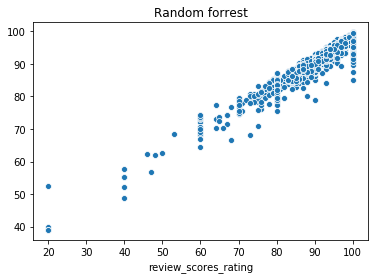

In [32]:
sns.scatterplot(y,y_pred_rf).set_title('Random forrest')

From the prediction result, we can see that random forrest has the best result. Let's see about the feature importance.

In [33]:
importances=clf_rf.feature_importances_
df_importances = pd.concat([pd.DataFrame(x.columns,columns=['column_name']),pd.DataFrame(importances,columns=['importances'])], axis=1)
df_importances = df_importances.sort_values('importances',ascending=False)
df_importances.reset_index()

,index,column_name,importances
0,7,price,0.161045
1,53,host_is_superhost,0.051623
2,1,host_total_listings_count,0.048781
3,0,host_listings_count,0.045417
4,2,accommodates,0.030508
...,...,...,...
101,82,South Boston Waterfront,0.000000
102,61,Allston,0.000000
103,81,South Boston,0.000000
104,91,Entire Floor,0.000000


<Figure size 432x288 with 0 Axes>

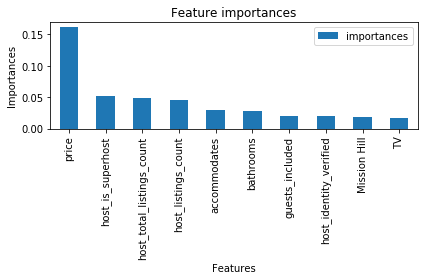

In [34]:
plt.figure()
df_importances.sort_values('importances',ascending=False).head(10).plot(x='column_name', y='importances',kind='bar', title='Feature importances')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.tight_layout()
plt.savefig('Importances',quality=100, optimize=True)

Price has the highest features importance value with host_is_superhost the second. Host_is_superhost is consistent with our earlier analysis that it has high correlation with ratings and logically it is one of the indicators of good host